In [1]:
import os
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings
warnings.filterwarnings("ignore")
import tarfile

from terratorch.registry import BACKBONE_REGISTRY, TERRATORCH_BACKBONE_REGISTRY, TERRATORCH_DECODER_REGISTRY

/Users/samuel.omole/Desktop/repos/geofm/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


# Extract Sen1Floods11 dataset
Check [original publication](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.pdf) and [here](https://github.com/cloudtostreet/Sen1Floods11) for more about the Sen1Floods11 dataset

In [ ]:
# dataset_root = "/Users/samuel.omole/Desktop/repos/geofm_datasets"
# url = "https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS"
# archive = dataset_root + "/sen1floods11_v1.1.tar.gz"
# extract_dir = dataset_root + "/sen1floods11_v1.1"

# # download if missing
# if not os.path.isfile(archive):
#     gdown.download(url, output=archive, quiet=False)

# # extract if not already extracted
# if not os.path.isdir(extract_dir):
#     with tarfile.open(archive, "r:gz") as tar:
#         tar.extractall(path=dataset_root)

## Analysing the dataset

In [2]:
!ls "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1"
# !ls "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/data"
# !ls "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/splits"
# !ls "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/data/S2L1CHand/" | head
# !ls "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/data/S2L1CHand/" | wc -l # 446 hand labelled data
# !head -n 5 "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/splits/flood_train_data.txt" # prefixes for dataset
# !wc -l "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/splits/flood_train_data.txt"
# !wc -l "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/splits/flood_test_data.txt"
# !wc -l "/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1/splits/flood_valid_data.txt"

Sen1Floods11_Metadata.geojson splits
data


# Preparing dataset with TerraTorch datamodule
Check TerraTorch details in [publication](https://arxiv.org/pdf/2503.20563) and in the [repository](https://github.com/IBM/terratorch)

In [3]:
dataset_path = Path("/Users/samuel.omole/Desktop/repos/geofm_datasets/sen1floods11_v1.1") # path to dataset

datamodule = terratorch.datamodules.GenericMultiModalDataModule(
    task="segmentation",
    batch_size=8,
    num_workers=2,
    num_classes=2,
    # Define input modalities. The names must match the keys in the following dicts.
    modalities=["S2L1C", "S1GRD"],
    rgb_modality="S2L1C",  # Used for plotting. Defaults to the first modality if not provided.
    rgb_indices=[3,2,1],  # RGB channel positions in the rgb_modality.

    # Define data paths as dicts using the modality names as keys.
    train_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    train_label_data_root=dataset_path / "data/LabelHand",
    val_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    val_label_data_root=dataset_path / "data/LabelHand",
    test_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    test_label_data_root=dataset_path / "data/LabelHand",

    # Define split files
    train_split=dataset_path / "splits/flood_train_data.txt",
    val_split=dataset_path / "splits/flood_valid_data.txt",
    test_split=dataset_path / "splits/flood_test_data.txt",
    
    # Define suffix
    image_grep={
        "S2L1C": "*_S2Hand.tif",
        "S1GRD": "*_S1Hand.tif",
    },
    label_grep="*_LabelHand.tif",
    
    # With TerraTorch, you can select a subset of the dataset bands as model inputs by providing dataset_bands (all bands in the data) and output_bands (selected bands). This setting is optional for all modalities and needs to be provided as dicts.
    # Here is an example for with S-1 GRD. You could change the output to ["VV"] to only train on the first band. Note that means and stds must be aligned with the output_bands (equal length of values). 
    dataset_bands={
        "S1GRD": ["VV", "VH"]
    },
    output_bands={
        "S1GRD": ["VV", "VH"]
    },

    # Define standardization values. We use the pre-training values here and providing the additional modalities is not a problem, which makes it simple to experiment with different modality combinations. Alternatively, use the dataset statistics that you can generate using `terratorch compute_statistics -c config.yaml` (requires concat_bands: true for this multimodal datamodule).
    means={
      "S2L1C": [2357.089, 2137.385, 2018.788, 2082.986, 2295.651, 2854.537, 3122.849, 3040.560, 3306.481, 1473.847, 506.070, 2472.825, 1838.929],
    #   "S2L2A": [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648],
      "S1GRD": [-12.599, -20.293],
    #   "S1RTC": [-10.93, -17.329],
    #   "RGB": [87.271, 80.931, 66.667],
    #   "DEM": [670.665]
    },
    stds={
      "S2L1C": [1624.683, 1675.806, 1557.708, 1833.702, 1823.738, 1733.977, 1732.131, 1679.732, 1727.26, 1024.687, 442.165, 1331.411, 1160.419],
    #   "S2L2A": [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311],
      "S1GRD": [5.195, 5.890],
    #   "S1RTC": [4.391, 4.459],
    #   "RGB": [58.767, 47.663, 42.631],
    #   "DEM": [951.272],
    },
    
    # albumentations supports shared transformations and can handle multimodal inputs. 
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensorV2() by default if not provided
    test_transform=None,
    
    no_label_replace=-1,  # Replace NaN labels. defaults to -1 which is ignored in the loss and metrics.
    no_data_replace=0,  # Replace NaN data
)

# Setup train and val datasets
datamodule.setup("fit")

INFO:terratorch:Train dataset: 252
INFO:terratorch:Val dataset: 89


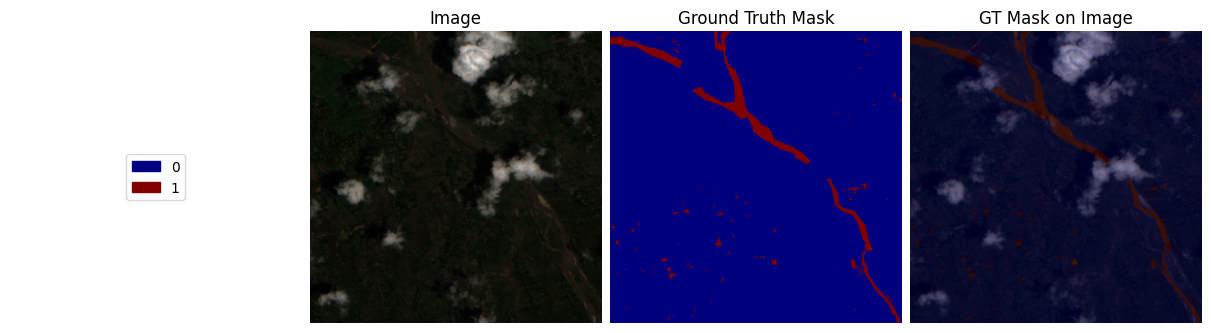

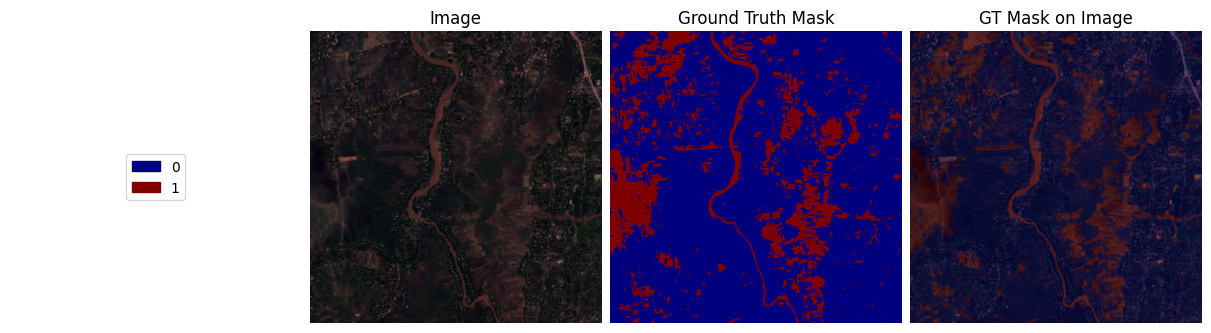

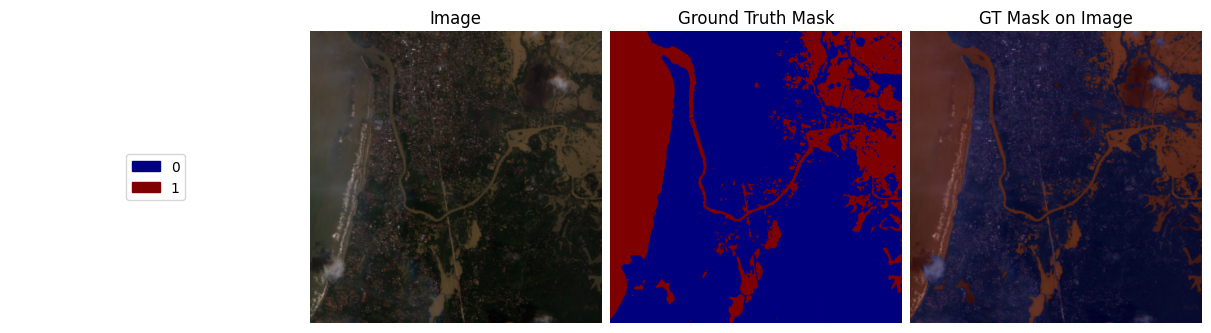

In [4]:
val_dataset = datamodule.val_dataset
train_dataset = datamodule.train_dataset
train_dataset.plot(train_dataset[50]) # to show some random plots of the training data
plt.show()
train_dataset.plot(train_dataset[57])
plt.show()
train_dataset.plot(train_dataset[200])
plt.show()

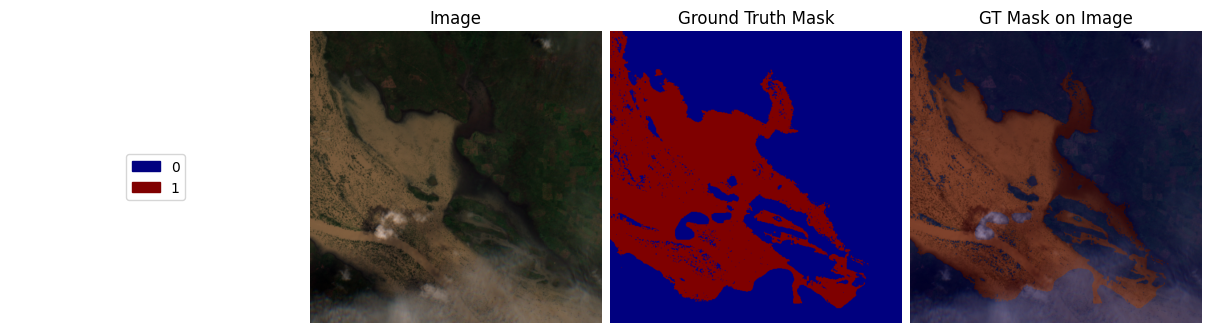

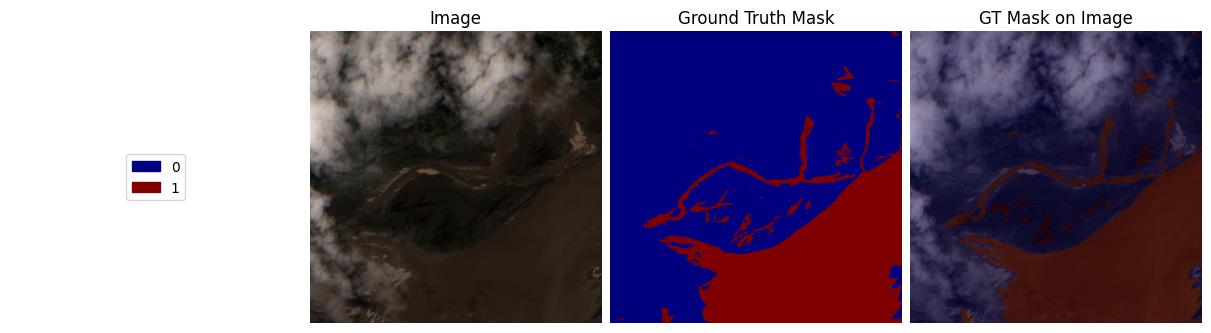

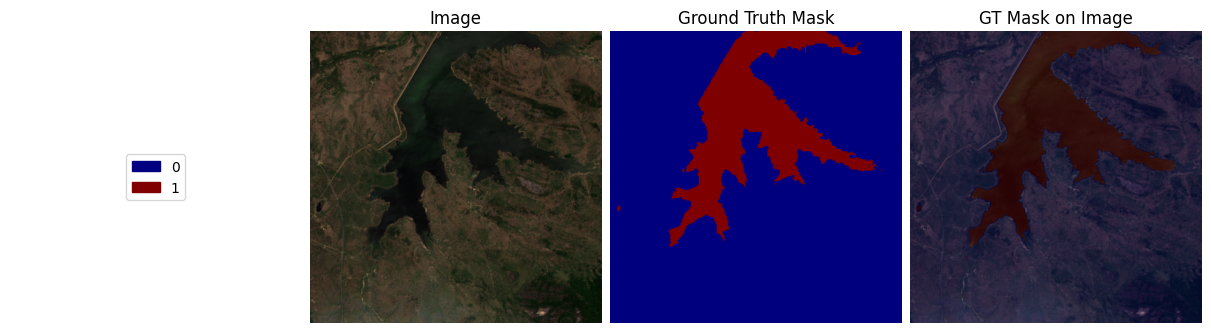

In [5]:
val_dataset.plot(val_dataset[8])
plt.show()
val_dataset.plot(val_dataset[15])
plt.show()
val_dataset.plot(val_dataset[68])
plt.show()

In [6]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

INFO:terratorch:Test dataset: 90


90

In [ ]:
# list(train_dataset)[0]

# Exploring the [TerraTorch](https://ibm.github.io/terratorch/quick_start/) model registry

In [ ]:
# Print all TerraMind v1 backbones.  
[backbone
 for backbone in TERRATORCH_BACKBONE_REGISTRY
 if 'terramind_v1'on

In [ ]:
# Available decoders
list(TERRATORCH_DECODER_REGISTRY)

In [ ]:
model = BACKBONE_REGISTRY.build("terramind_v1_small", pretrained=True)
model
# model.encoder 

# Building TerraMind and fine-tuning via PyTorch Lightning
Refer to the [publication](https://arxiv.org/pdf/2504.11171) and [repository](https://github.com/IBM/terramind/tree/main) for more details

In [7]:
pl.seed_everything(0)

# By default, TerraTorch saves the model with the best validation loss. You can overwrite this by defining a custom ModelCheckpoint, e.g., saving the model with the highest validation mIoU.  
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="../output/terramind_small_sen1floods11/checkpoints/", # change as appropriate
    mode="max",
    monitor="val/mIoU", # Variable to monitor
    filename="best-mIoU",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="cpu", # "auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision=32, #"16-mixed",  # Speed up training with half precision, delete for full precision training.
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=50, # For demos but can increase further to train for longer
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="../output/terramind_small_sen1floods11/", # change as appropriate
)

# Segmentation mask that build the model and handles training and validation steps.  
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",  # Combines a backbone with necks, the decoder, and a head
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_small", # change to specific model e.g., for large version: terramind_v1_large 
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L1C", "S1GRD"],
        # Optionally, define the input bands. This is only needed if you select a subset of the pre-training bands, as explained above.
        # "backbone_bands": {"S1GRD": ["VV"]},
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_base & small
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {"name": "ReshapeTokensToImage",
             "remove_cls_token": False},  # TerraMind is trained without CLS token, which needs to be specified.
            {"name": "LearnedInterpolateToPyramidal"}  # Some decoders like UNet or UperNet expect hierarchical features. Therefore, we need to learn a upsampling for the intermediate embedding layers when using a ViT like TerraMind.
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },
    
    loss="dice",  # We recommend dice for binary tasks and ce for tasks with multiple classes. 
    optimizer="AdamW",
    lr=2e-5,  # The optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4. You can perform hyperparameter optimization using terratorch-iterate.  
    ignore_index=-1,
    freeze_backbone=True, # Only used to speed up fine-tuning in this demo, we highly recommend fine-tuning the backbone for the best performance. 
    freeze_decoder=False,  # Should be false in most cases as the decoder is randomly initialized.
    plot_on_val=True,  # Plot predictions during validation steps  
    class_names=["Others", "Water"]  # optionally define class names
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [8]:
# run training
trainer.fit(model, datamodule=datamodule)

INFO:terratorch:Train dataset: 252
INFO:terratorch:Val dataset: 89


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │ 32.2 M │ train │
│ 1 │ criterion     │ DiceLoss         │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 9.4 M                                                                                            
Non-trainable params: 22.8 M                                                                                       
Total params: 32.2 M                                                                                               
Total estimated model params size (MB): 128                                                                        
Modules in train mode: 287                                                                                         
Modules in eval mode: 0

INFO:terratorch:Checking dataset stackability for val split
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:terratorch:Checking dataset stackability for train split
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you ha

In [9]:
# Test the fine-tuned model
best_ckpt_path = "../output/terramind_small_sen1floods11/checkpoints/best-mIoU.ckpt"
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

# Note: This demo only trains for 5 epochs by default, which does not result in good test metrics.

INFO:terratorch:Test dataset: 90
INFO: Restoring states from the checkpoint path at ../output/terramind_small_sen1floods11/checkpoints/best-mIoU.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ../output/terramind_small_sen1floods11/checkpoints/best-mIoU.ckpt
INFO: Loaded model weights from the checkpoint at ../output/terramind_small_sen1floods11/checkpoints/best-mIoU.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ../output/terramind_small_sen1floods11/checkpoints/best-mIoU.ckpt
INFO:terratorch:Checking dataset stackability for test split
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy        │     0.9390840530395508     │
│ test/Class_Accuracy_Others │     0.9830871820449829     │
│ test/Class_Accuracy_Water  │     0.8950809240341187     │
│       test/F1_Score        │     0.9365777969360352     │
│      test/IoU_Others       │     0.9685608744621277     │
│       test/IoU_Water       │     0.8003844022750854     │
│    test/Pixel_Accuracy     │     0.9720802307128906     │
│         test/loss          │    0.19004279375076294     │
│         test/mIoU          │     0.8844726085662842     │
│      test/mIoU_Micro       │     0.9456773996353149     │
└────────────────────────────┴────────────────────────────┘

[{'test/loss': 0.19004279375076294,
  'test/Accuracy': 0.9390840530395508,
  'test/Class_Accuracy_Others': 0.9830871820449829,
  'test/Class_Accuracy_Water': 0.8950809240341187,
  'test/F1_Score': 0.9365777969360352,
  'test/IoU_Others': 0.9685608744621277,
  'test/IoU_Water': 0.8003844022750854,
  'test/Pixel_Accuracy': 0.9720802307128906,
  'test/mIoU': 0.8844726085662842,
  'test/mIoU_Micro': 0.9456773996353149}]

INFO:terratorch:Checking dataset stackability for test split
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


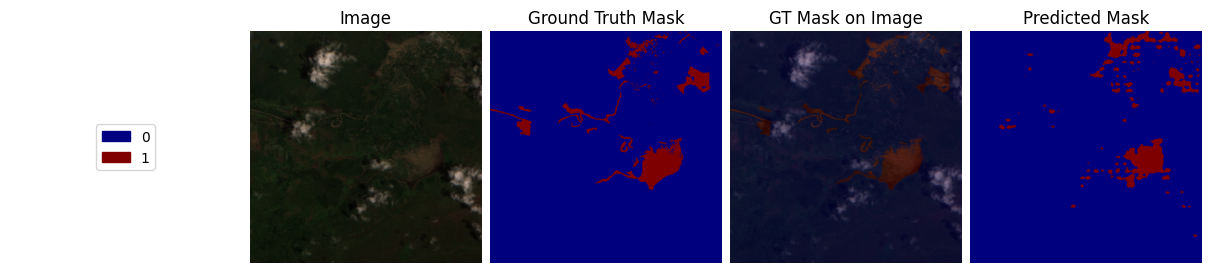

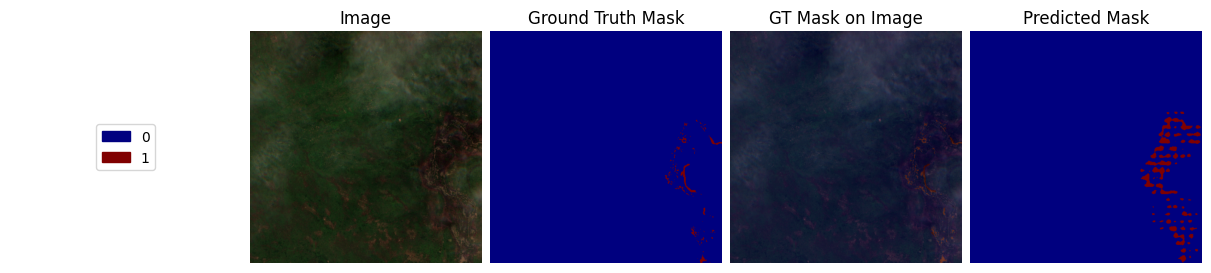

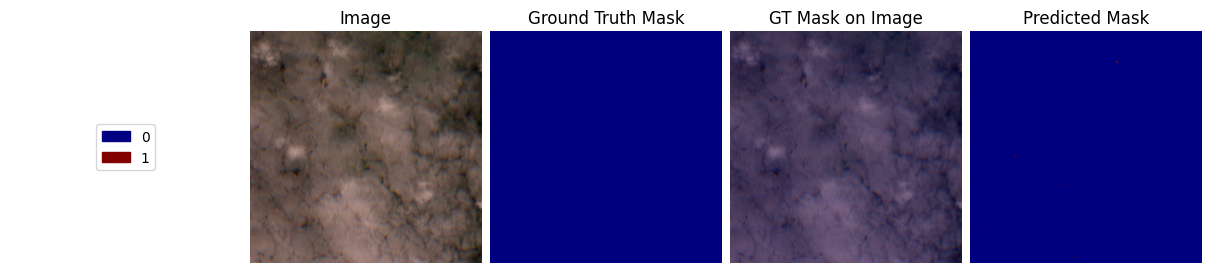

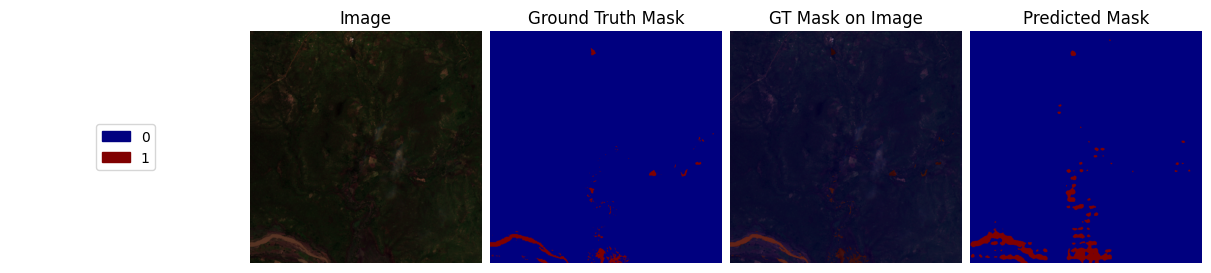

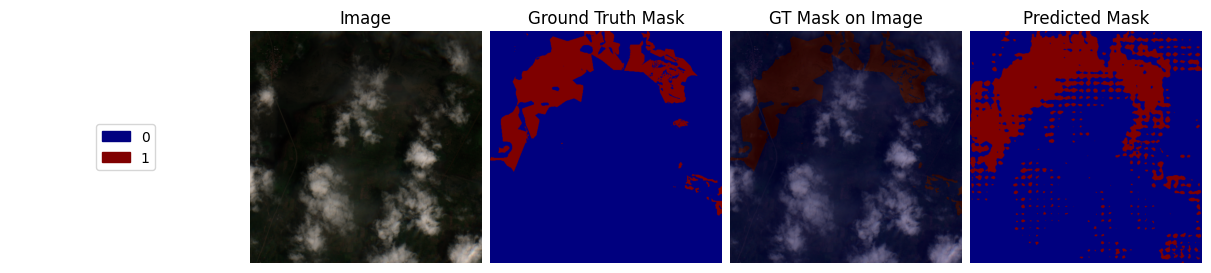

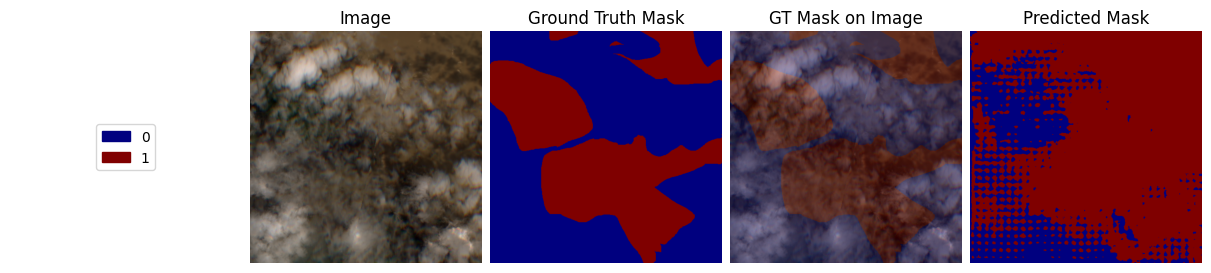

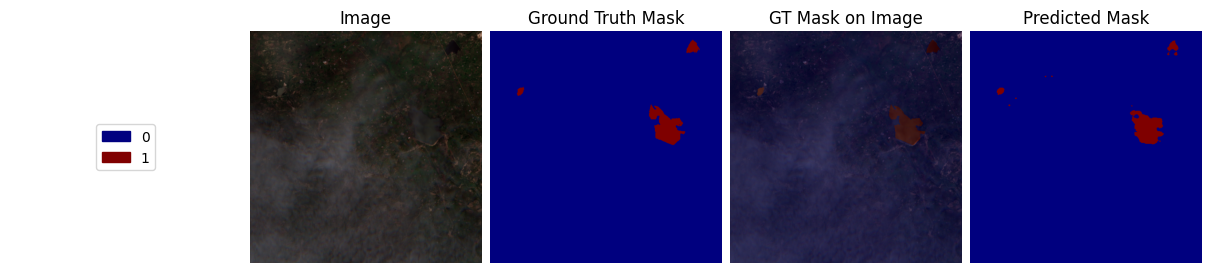

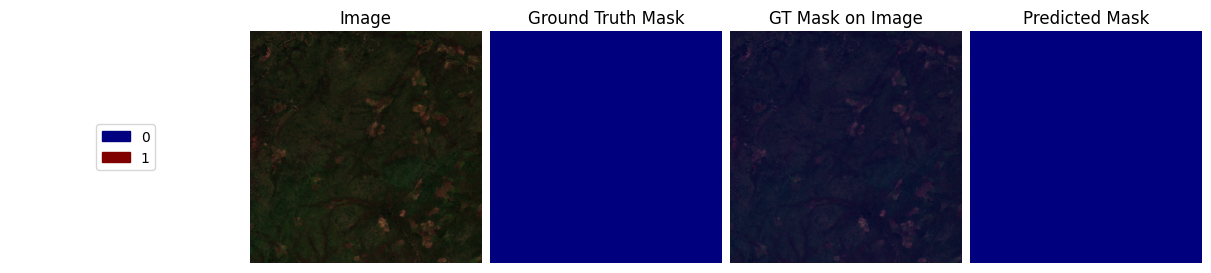

In [10]:
# Now we can use the model for predictions and plotting
model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
)

test_loader = datamodule.test_dataloader()
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"]
    for mod, value in images.items():
        images[mod] = value.to(model.device)
    masks = batch["mask"].numpy()

    with torch.no_grad():
        outputs = model(images)
    
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(8):
    sample = {
        "image": batch["image"]["S2L1C"][i].cpu(),
        "mask": batch["mask"][i],
        "prediction": preds[i],
    }
    test_dataset.plot(sample)
    plt.show()
    
# Note: This demo only trains for 5 epochs by default, which does not result in good predictions. 

In [ ]:
# TODO: How to do a zero-shot implementation without fine-tuning
# TODO: Modify code to randomly predict between batches and plot results
# TODO: Fine-tune backbone parameters instead of freezing them
# TODO: Use terratorch-iterate to optimise hyperparameters
# TODO: Look into different loss functions that could be applied / Understand the specific metrics used in trainer.test()
# TODO: May implement CLI method of fine-tuning